# Pre-processing the Data


### Notebook Imports

In [121]:
from os import walk
from os.path import join
import pandas as pd
import matplotlib.pyplot as plt

#used in data preprocessing
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud
from PIL import Image
import numpy as np

from sklearn.model_selection import train_test_split

from bs4 import BeautifulSoup

%matplotlib inline

### Constant

In [122]:
#constant var to store the file path such that we don't have to write the entire thing again and again
EXAMPLE_FILE = 'SpamData/01_Processing/practice_email.txt'

SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'
TRAINING_DATA_FILE = 'SpamData/02_Training/train-data.txt'
TEST_DATA_FILE = 'SpamData/02_Training/test-data.txt'

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE=2500

DATA_JSON_FILE = 'SpamData/01_Processing/email-text-data.json'
WORD_ID_FILE = 'SpamData/01_Processing/word-by-id.csv'

WHALE_FILE = 'SpamData/01_Processing/wordcloud_resources/whale-icon.png'
SKULL_FILE = 'SpamData/01_Processing/wordcloud_resources/skull-icon.png'
THUMBS_UP_FILE='SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN_FILE='SpamData/01_Processing/wordcloud_resources/thumbs-down.png'
CUSTOM_FONT_FILE='SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf'


In [123]:
stream = open(EXAMPLE_FILE)     #open the file ; a stream object is send back ; this file has only one email
message = stream.read()         #read the file
stream.close()    

In [281]:
# extracting from only one email
# extracting the msg from the email
stream = open(EXAMPLE_FILE)

#the code part for extracting only the msg part
is_body = False
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    elif line=='\n':        #since we know that the head and body is separated by a new line(\n) character
        is_body=True
#extraction done

stream.close()

email_body = '\n'.join(lines)
print(email_body)
    



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

In [282]:
#function for extracting msg from all the emails
def email_body_generator(path):
    for root,dirnames,filenames in walk(path):
        for file_name in filenames:
            
            filepath=join(root,file_name)
            
            stream = open(filepath,encoding='latin-1')

            
            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line=='\n':        #since we know that the head and body is separated by a new line(\n) character
                    is_body=True

            stream.close()

            email_body = '\n'.join(lines)
            yield file_name, email_body

In [126]:
def df_from_directory(path,classification):
    rows = []
    row_names = []
    
    for file_name ,email_body in email_body_generator(path):
        rows.append({'MESSAGE':email_body,'CATEGORY':classification})
        row_names.append(file_name)
    return pd.DataFrame(rows,index=row_names)

In [127]:
spam_emails = df_from_directory(SPAM_1_PATH,1)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH,1))


In [128]:
spam_emails.shape

(1898, 2)

In [129]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH,0)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH,0))

In [130]:
ham_emails.shape

(3901, 2)

In [131]:
data = pd.concat([spam_emails,ham_emails])
data.shape

(5799, 2)

## CLEANING THE DATA

In [132]:
#checking for missing values (null values)
data['MESSAGE'].isnull().any()

False

In [133]:
#checking for empty messages (msg len of 0 {""})
(data['MESSAGE'].str.len()==0).any()

True

In [134]:
#checking number of entries with empty values
(data['MESSAGE'].str.len()==0).sum()

3

In [135]:
#checking number of entries with null values
(data['MESSAGE'].isnull()).sum()

0

In [136]:
#finding the index at which we have empty values
data[data['MESSAGE'].str.len()==0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [137]:
#dropping the system files (cmds)
data.drop(['cmds'],inplace=True)

In [138]:
data.shape

(5796, 2)

In [139]:
#Adding document ids in place of index(originally index was file name)
document_ids = range(0,len(data.index))
document_ids

range(0, 5796)

In [140]:
data['FILE_NAME']=data.index

In [141]:
data['DOC_ID']=document_ids

In [142]:
data.set_index('DOC_ID',inplace=True)

In [143]:
data

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these:\n\n1) Slim Dow...,1,00005.57696a39d7d84318ce497886896bf90d
...,...,...,...
5791,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0,01396.61983fbe6ec43f55fd44e30fce24ffa6
5792,"> >-- be careful when using this one.) Also, t...",0,01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7
5793,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0,01398.169b51731fe569f42169ae8f948ec676


In [144]:
#saving the data to file using pandas
data.to_json(DATA_JSON_FILE)

## DATA VISUALISATION USING PIE CHART

In [145]:
# number of spam and ham emails in the data ; 0 ==>ham & 1 ==>spam
data['CATEGORY'].value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [146]:
# storing the above number in variables
amount_of_spam=data['CATEGORY'].value_counts()[1]
amount_of_ham=data['CATEGORY'].value_counts()[0]

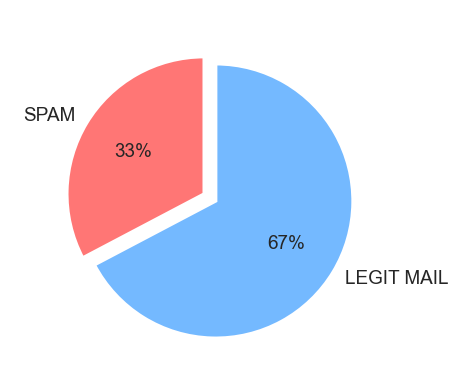

In [147]:
#pie chart visualisation
category_names = ['SPAM','LEGIT MAIL']
sizes =[amount_of_spam,amount_of_ham]
custom_colors=['#ff7675','#74b9ff']

plt.figure(figsize=(2,2),dpi=227)
plt.pie(sizes,labels=category_names,textprops={'fontsize':6},startangle=90,autopct='%1.0f%%',colors=custom_colors,explode=[0,0.1])
plt.show()

## DATA VISUALISATION USING DONUT CHART

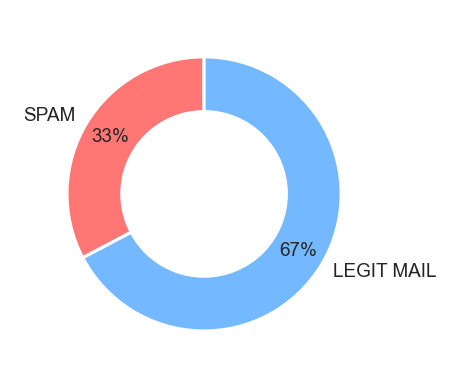

In [148]:
#donut chart visualisation
category_names = ['SPAM','LEGIT MAIL']
sizes =[amount_of_spam,amount_of_ham]
custom_colors=['#ff7675','#74b9ff']

plt.figure(figsize=(2,2),dpi=227)
plt.pie(sizes,labels=category_names,textprops={'fontsize':6},startangle=90,autopct='%1.0f%%',colors=custom_colors,pctdistance=0.8)

#draw circle
centre_cirlce = plt.Circle((0,0),radius=0.6,fc='white')
plt.gca().add_artist(centre_cirlce)
plt.show()

## DATA PRE-PROCESSING : involves following 6 steps

Download the NLTK resources (Tokenizer & Stopwords)

1) Convertion to lower case
 
2) Tokenizing

3) Removing Stopwords

4) Removing Punctuations 

5) Word Stem and Stemming

6) Removing HMTL tags from the emails


### DOWNLOAD THE NLTK RESOURCES (Tokenizer & Stopwords)

In [149]:
nltk.download('punkt')   #for tokenizing
nltk.download('stopwords') #for stopwords removal


[nltk_data] Downloading package punkt to C:\Users\SUVARNA
[nltk_data]     THAPA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\SUVARNA
[nltk_data]     THAPA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## DATA PREPROCESSING OF THE ALL THE DATA

## Function for email processing

In [285]:
# function to perfrom above 6 steps on each msg extracted
def clean_msg_no_html(message,stemmer=PorterStemmer(),stop_words=set(stopwords.words('english'))):
    filtered_words = []
    
    #(6)removing html tags
    soup=BeautifulSoup(message,'html.parser')
    cleaned_text = soup.get_text()
    #converting to (1) lower case and (2) splitting(tokenize) the words
    words = word_tokenize(cleaned_text.lower())
    
    for word in words:
        #checking if the word is a (3)stop_word or not and whether it is a (4)punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))   #(5) stemming the words
    
    return filtered_words

In [284]:
# example 1 of cleaned and preprocessed email data ; done on email_body
print(clean_msg_no_html(email_body))

['dear', 'mr', 'still', 'good', 'tide', 'staff', 'festiv', 'season', 'ahead', 'christma', 'crux', 'fulli', 'qualifi', 'santa', 'clau', 'wonder', 'whether', 'might', 'consid', 'run', 'santa', 'grotto', 'store', 'wait', 'probabl', 'think', 'make', 'special', 'well', 'first', 'made', 'sever', 'chang', 'characteris', 'father', 'christma', 'rather', 'greet', 'children', 'shout', 'ho', 'ho', 'ho', 'prefer', 'whisper', 'phrase', 'depend', 'unfathom', 'cruel', 'world', 'live', 'addit', 'gift', 'rang', 'felt', 'hoop', 'holder', 'note', 'also', 'enclos', 'sketch', 'radic', 'redesign', 'santa', 'outfit', 'renam', 'charact', 'lord', 'buckl', 'would', 'interest', 'employ', 'promis', 'never', 'let', 'look', 'forward', 'hear', 'best', 'wish', 'robin', 'cooper', 'excerpt', 'book', 'timewast', 'letter', 'robin', 'cooper']


In [280]:
# example 2 of cleaned and preprocessed email data ; done on msg at index 2
print(clean_msg_no_html(data.at[2,'MESSAGE']))

['fight', 'risk', 'cancer', 'http', 'slim', 'guarante', 'lose', 'lb', 'day', 'http', 'get', 'child', 'support', 'deserv', 'free', 'legal', 'advic', 'http', 'join', 'web', 'fastest', 'grow', 'singl', 'commun', 'http', 'start', 'privat', 'photo', 'album', 'onlin', 'http', 'wonder', 'day', 'offer', 'manag', 'prizemama', 'wish', 'leav', 'list', 'pleas', 'use', 'link', 'http', 'zzzz']


 ## Applying Cleaning and Tokenization to all messages -- storing it in nested_list2(series)

### Slicing dataframe and series and creating subsets

In [155]:
%%time
nested_list2 = data.MESSAGE.apply(clean_msg_no_html)

C:\Users\SUVARNA THAPA\anaconda3\lib\site-packages\bs4\__init__.py:414: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


Wall time: 45.1 s


In [156]:
nested_list2


DOC_ID
0       [save, life, insur, spend, life, quot, save, g...
1       [fight, risk, cancer, http, slim, guarante, lo...
2       [fight, risk, cancer, http, slim, guarante, lo...
3       [adult, club, offer, free, membership, instant...
4       [thought, might, like, slim, guarante, lose, l...
                              ...                        
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, Length: 5796, dtype: object

## using logic to slice dataframe

In [157]:
#retrieving the data which is spam (CATEGORY = 1)
data[data.CATEGORY==1]

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these:\n\n1) Slim Dow...,1,00005.57696a39d7d84318ce497886896bf90d
...,...,...,...
1891,"<html>\n\n<head>\n\n<meta http-equiv=""content-...",1,01396.e80a10644810bc2ae3c1b58c5fd38dfa
1892,This is a multi-part message in MIME format.\n...,1,01397.f75f0dd0dd923faefa3e9cc5ecb8c906
1893,"Dear Subscriber,\n\n\n\nIf I could show you a ...",1,01398.8ca7045aae4184d56e8509dc5ad6d979


In [158]:
#storing the index value(doc_id , in the data dataframe) of spam messages  
doc_ids_spam = data[data.CATEGORY==1].index

In [159]:
#storing the index value(doc_id , in the data dataframe) of ham messages  
doc_ids_ham = data[data.CATEGORY==0].index

In [160]:
type(doc_ids_ham)

pandas.core.indexes.numeric.Int64Index

In [161]:
#nested_list_ham : a series containing only ham messages
nested_list_ham = nested_list2.loc[doc_ids_ham] 

In [162]:
nested_list_ham.head()

DOC_ID
1896    [date, wed, aug, chri, garrigu, ca, reproduc, ...
1897    [martin, post, tasso, papadopoulo, greek, scul...
1898    [man, threaten, explos, moscow, thursday, augu...
1899    [klez, viru, wo, die, alreadi, prolif, viru, e...
1900    [ad, cream, spaghetti, carbonara, effect, past...
Name: MESSAGE, dtype: object

In [163]:
#nested_list_spam : a series containing only spam messages
nested_list_spam = nested_list2.loc[doc_ids_spam] 

In [164]:
nested_list_spam.head()

DOC_ID
0    [save, life, insur, spend, life, quot, save, g...
1    [fight, risk, cancer, http, slim, guarante, lo...
2    [fight, risk, cancer, http, slim, guarante, lo...
3    [adult, club, offer, free, membership, instant...
4    [thought, might, like, slim, guarante, lose, l...
Name: MESSAGE, dtype: object

### Finding the frequency of  each word(tokens) in ham messages list

In [165]:
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]

In [166]:
# normal_words means here as ham_words
normal_words=pd.Series(flat_list_ham).value_counts()
normal_words.shape[0]
#there are 20815 ham words in total in the data dataframe

20815

In [167]:
# retrieving the top 10 most frequent words in the ham list
normal_words[:10]

http      7563
use       3633
list      2880
one       2373
get       2286
mail      2255
would     2003
like      1931
messag    1849
work      1800
dtype: int64

### Finding the frequency of  each word(tokens) in spam messages list

In [168]:
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]

In [169]:
spam_words=pd.Series(flat_list_spam).value_counts()
spam_words.shape[0]
#there are 13242 spam words in total in the data dataframe

13242

In [170]:
# retrieving the top 10 most frequent words in the ham list
spam_words[:10]

http      3097
email     3090
free      2585
click     2058
receiv    1989
list      1971
get       1914
pleas     1852
busi      1792
order     1746
dtype: int64

## CREATING A WORD CLOUD of ham and spam messages

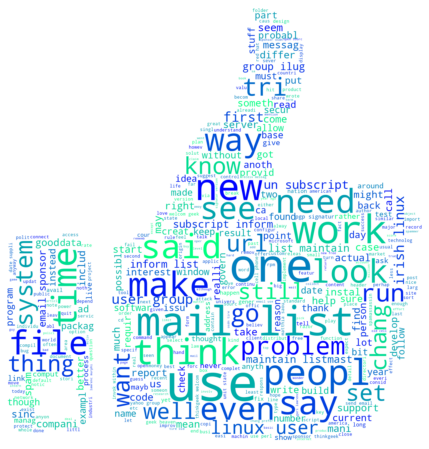

In [171]:
#word cloud of ham messages words 
icon=Image.open(THUMBS_UP_FILE)
image_mask = Image.new(mode='RGB',size=icon.size,color=(255,255,255))
image_mask.paste(icon,box=icon)

rgb_array = np.array(image_mask)

#generate the text as a string for the word cloud
ham_str = ' '.join(flat_list_ham)
word_cloud2=WordCloud(mask=rgb_array,background_color='white',max_words=400,colormap='winter').generate(ham_str)
plt.figure(figsize=[16,8])
plt.imshow(word_cloud2,interpolation='bilinear')
plt.axis('off')
plt.show()


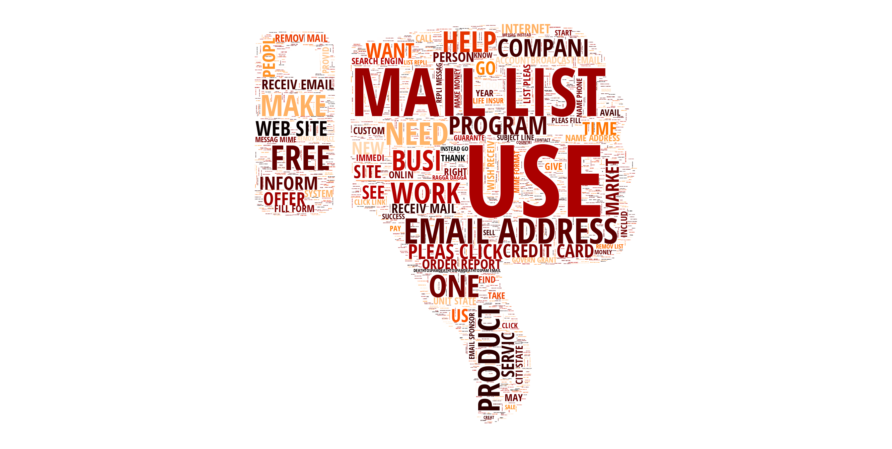

In [172]:
#word cloud of spam messages words 
icon=Image.open(THUMBS_DOWN_FILE)
image_mask = Image.new(mode='RGB',size=icon.size,color=(255,255,255))
image_mask.paste(icon,box=icon)

rgb_array = np.array(image_mask)

#generate the text as a string for the word cloud
spam_str = ' '.join(flat_list_spam)
word_cloud2=WordCloud(mask=rgb_array,background_color='white',max_words=2000,colormap='gist_heat',max_font_size=300,font_path=CUSTOM_FONT_FILE).generate(spam_str.upper())
plt.figure(figsize=[16,8])
plt.imshow(word_cloud2,interpolation='bilinear')
plt.axis('off')
plt.show()

## Generate Vocabulary & Dictionary 
### Vocabulary means series of the top 2500(VOCAB_SIZE) most frequent words

In [173]:
stemmed_nested_list = data.MESSAGE.apply(clean_msg_no_html)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

C:\Users\SUVARNA THAPA\anaconda3\lib\site-packages\bs4\__init__.py:414: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [174]:
#this has the list of unique words with their frquency
unique_words = pd.Series(flat_stemmed_list).value_counts()


In [175]:
unique_words

http             10660
use               5019
list              4851
email             4367
get               4200
                 ...  
persistentnod        1
excori               1
aileen               1
beng                 1
ctor                 1
Length: 27334, dtype: int64

In [176]:
frequent_words = unique_words[0:VOCAB_SIZE]

## Create Vocabulary DataFrame with a WORD_ID

In [177]:
word_ids=list(range(0,VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD' : frequent_words.index.values},index=word_ids)
vocab.index.name='WORD_ID'
vocab.head()

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get


## Saving the Vocabulary as a CSV File

In [178]:
vocab.to_csv(WORD_ID_FILE,index_label=vocab.index.name,header=vocab.VOCAB_WORD.name)

# Generate Features & a Sparse Matrix

### Creating a DataFrame with one Word per Column

In [179]:
type(stemmed_nested_list.tolist())

list

In [180]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())


In [181]:
word_columns_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,save,life,insur,spend,life,quot,save,g,famili,financi,...,None,None,None,None,None,None,None,None,None,None
1,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
2,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
3,adult,club,offer,free,membership,instant,access,site,user,name,...,None,None,None,None,None,None,None,None,None,None
4,thought,might,like,slim,guarante,lose,lb,day,http,fight,...,None,None,None,None,None,None,None,None,None,None


### Splitting the data set into training and testing parts

In [182]:
X_train,X_test,y_train,y_test = train_test_split(word_columns_df,data.CATEGORY,test_size=0.3,random_state=42)

In [183]:
X_train.index.name = X_test.index.name = 'DOC_ID'
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4675,interest,alway,wonder,thing,bad,exampl,goto,languag,support,goto,...,None,None,None,None,None,None,None,None,None,None
4220,url,http,date,final,gdc,europ,review,confernec,session,ect,...,None,None,None,None,None,None,None,None,None,None
2484,stephen,william,mailto,swilliam,weaken,food,transact,argument,note,neighborhood,...,None,None,None,None,None,None,None,None,None,None
2418,el,mon,sep,bitbitch,wrote,eugen,mani,homo,friend,lover,...,None,None,None,None,None,None,None,None,None,None
5110,music,school,joke,american,conductor,european,conductor,talk,european,conductor,...,None,None,None,None,None,None,None,None,None,None


In [184]:
y_test.head()

DOC_ID
4675    0
4220    0
2484    0
2418    0
5110    0
Name: CATEGORY, dtype: int64

### Creating a Sparse Matrix for the Training Data

In [185]:
word_index = pd.Index(vocab.VOCAB_WORD)

In [186]:
def make_sparse_matrix(df,indexed_words,labels):
    """
    Returns sparse matrix as dataframe.
    
    df: A dataframe with words in the columns with a document id as an index (X_train or X_test)
    indexed_words: index of words ordered by word id
    labels: caegort as a series (y_train or y_test)
    """
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_cols):
            
            word=df.iat[i,j]
            if word in word_set:
                doc_id=df.index[i]
                word_id=indexed_words.get_loc(word)
                category=labels.at[doc_id]
                
                item={'LABEL':category,'DOC_ID':doc_id,'OCCURENCE':1,'WORD_ID':word_id}
                
                dict_list.append(item)
    return pd.DataFrame(dict_list)

In [187]:
%%time
sparse_train_df = make_sparse_matrix(X_train,word_index,y_train)

Wall time: 3min 30s


In [188]:
sparse_train_df.shape

(429237, 4)

In [189]:
sparse_train_df.head()

,LABEL,DOC_ID,OCCURENCE,WORD_ID
0,0,4844,1,265
1,0,4844,1,1241
2,0,4844,1,503
3,0,4844,1,308
4,0,4844,1,254


In [190]:
sparse_train_df.tail()

,LABEL,DOC_ID,OCCURENCE,WORD_ID
429232,1,860,1,47
429233,1,860,1,1433
429234,1,860,1,26
429235,1,860,1,21
429236,1,860,1,126


### Combining Occurrences with the Pandas groupby() method

In [191]:
train_grouped = sparse_train_df.groupby(['DOC_ID','WORD_ID','LABEL']).sum()

In [192]:
train_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
0      2       1              1
       3       1              2
       4       1              1
       7       1              3
       11      1              1

In [193]:
train_grouped = train_grouped.reset_index()

In [194]:
train_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,0,2,1,1
1,0,3,1,2
2,0,4,1,1
3,0,7,1,3
4,0,11,1,1


In [195]:
train_grouped.shape

(258379, 4)

### Saving Training Data as .txt File

In [196]:
np.savetxt(TRAINING_DATA_FILE,train_grouped,fmt='%d')

### Creating a Sparse Matrix for the Testing Data
### Combining Occurrences with the Pandas groupby() method
### Saving Testing Data as .txt Filed

In [197]:
%%time
sparse_test_df = make_sparse_matrix(X_test,word_index,y_test)

Wall time: 1min 44s


In [198]:
test_grouped = sparse_test_df.groupby(['DOC_ID','WORD_ID','LABEL']).sum()
test_grouped = test_grouped.reset_index()
np.savetxt(TEST_DATA_FILE,test_grouped,fmt='%d')

## End of the Pre-proccessing of the data 
Tasks Accomplished:
=> cleaning,exploring,visualizing the data
=> proper .txt and json files are saved as checkpoints so that there is no need to re-run the code to get the proccessed data
=> these above files contains data that will be fed into the naive bayes classifier
=> all the text strings are now converted to numbers and the words are represented by their word_id
=> also counted the frequency each token(transformed words) occurs in the mails



# Training the Algorithm

## additional Constants

In [199]:
TOKEN_SPAM_PROB_FILE = 'SpamData/03_Testing/prob-spam.txt'
TOKEN_HAM_PROB_FILE = 'SpamData/03_Testing/prob-nonspam.txt'
TOKEN_ALL_PROB_FILE = 'SpamData/03_Testing/prob-all-tokens.txt'

TEST_FEATURE_MATRIX = 'SpamData/03_Testing/test-features.txt'
TEST_TARGET_FILE = 'SpamData/03_Testing/test-target.txt'

## Read and Load Features from .txt Files into NumPy Array

In [200]:
sparse_train_data = np.loadtxt(TRAINING_DATA_FILE,delimiter=' ',dtype=int)
sparse_test_data = np.loadtxt(TEST_DATA_FILE,delimiter=' ',dtype=int)

In [201]:
print('Nr of rows in training file',sparse_train_data.shape[0])
print('Nr of rows in test file',sparse_test_data.shape[0])

Nr of rows in training file 258379
Nr of rows in test file 117789


In [202]:
print('Nr of emails in training file',np.unique(sparse_train_data[:,0]).size)
print('Nr of emails in test file',np.unique(sparse_test_data[:,0]).size)

Nr of emails in training file 4013
Nr of emails in test file 1724


## Creating an empty dataframe and then populating it with token frequency to get the full sparse matrix

In [203]:
column_names= ['DOC_ID']+['CATEGORY']+list(range(0,VOCAB_SIZE))
len(column_names)

2502

In [204]:
index_names = np.unique(sparse_train_data[:,0])
index_names

array([   0,    1,    2, ..., 5791, 5794, 5795])

In [205]:
full_train_data = pd.DataFrame(index=index_names,columns=column_names)

In [206]:
# initially it has NaN as entries
full_train_data.head()

,DOC_ID,CATEGORY,0,1,2,3,4,5,6,7,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [207]:
# populating it with 0 instead of NaN as entries
full_train_data.fillna(value=0,inplace=True)

In [208]:
full_train_data.head()

,DOC_ID,CATEGORY,0,1,2,3,4,5,6,7,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [209]:
#creating a full_matrix (populating the above dataframe with the frequency of each token)
def make_full_matrix(sparse_matrix,nr_words,doc_idx=0,word_idx=1,cat_idx=2,freq_idx=3):
    #creating empty dataframe and populating it with value 0
    column_names= ['DOC_ID']+['CATEGORY']+list(range(0,VOCAB_SIZE))
    doc_id_names = np.unique(sparse_matrix[:,0])
    full_matrix = pd.DataFrame(index=doc_id_names,columns=column_names)
    full_matrix.fillna(value=0,inplace=True)
    
    #taking values from the sparse matrix and putting it into the full matrix
    for i in range(sparse_matrix.shape[0]):
        doc_nr=sparse_matrix[i][doc_idx]
        word_id=sparse_matrix[i][word_idx]
        label=sparse_matrix[i][cat_idx]
        occurrence=sparse_matrix[i][freq_idx]
    
        full_matrix.at[doc_nr,'DOC_ID']=doc_nr
        full_matrix.at[doc_nr,'CATEGORY']=label
        full_matrix.at[doc_nr,word_id]=occurrence
    
    full_matrix.set_index('DOC_ID',inplace=True)
    return full_matrix

In [210]:
%%time
full_train_data = make_full_matrix(sparse_train_data,VOCAB_SIZE)

Wall time: 9.71 s


In [211]:
full_train_data.head()

,CATEGORY,0,1,2,3,4,5,6,7,8,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
DOC_ID,,,,,,,,,,,,,,,,,,,,,
0,1,0,0,1,2,1,0,0,3,0,...,0,0,0,0,0,0,0,0,0,0
1,1,7,1,2,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,6,1,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,6,0,0,2,4,0,3,14,0,...,0,0,0,0,0,0,0,0,0,0
4,1,5,1,2,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [212]:
full_train_data.tail()

,CATEGORY,0,1,2,3,4,5,6,7,8,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
DOC_ID,,,,,,,,,,,,,,,,,,,,,
5789,0,3,1,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5790,0,1,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5791,0,3,1,0,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5794,0,1,1,1,0,0,1,2,0,0,...,0,0,0,0,0,0,0,0,0,0
5795,0,3,4,2,0,5,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0


# Training the Naive Bayes Model
## Calculating the Probability of Spam

In [213]:
# Calculating the probability of spam - the percent of spam messages in the training dataset and storing this value in a 
# variable called prob_spam

In [214]:
# the prob_spam = no. of spam msg in dataset / no. of msg in dataset
print('no. of spam msg in dataset : ',full_train_data.CATEGORY.sum())
print('no. of msg in dataset : ',full_train_data.CATEGORY.size)
prob_spam = full_train_data.CATEGORY.sum()/full_train_data.CATEGORY.size
print('The probabilty of spam msg is : ',prob_spam)

no. of spam msg in dataset :  1248
no. of msg in dataset :  4013
The probabilty of spam msg is :  0.310989284824321


In [215]:
# finding the number of tokens in our dataset
full_train_features = full_train_data.loc[:,full_train_data.columns != 'CATEGORY']
email_lengths = full_train_features.sum(axis=1)
email_lengths.shape

(4013,)

In [216]:
#tokens(word_id) with their respective frequency
email_lengths

DOC_ID
0        87
1        53
2        40
3       183
4        43
       ... 
5789     18
5790     72
5791     46
5794     57
5795    264
Length: 4013, dtype: int64

In [217]:
#finding the total number of words in the dataset (summing the frequency of all the words)
total_wc = email_lengths.sum()
total_wc

429237

In [218]:
#tokens(word_id, spam tokens only) with their respective frequency 
spam_lengths = email_lengths[full_train_data.CATEGORY==1]
spam_lengths

DOC_ID
0        87
1        53
2        40
3       183
4        43
       ... 
1885     45
1887     26
1889    115
1890     26
1895    163
Length: 1248, dtype: int64

In [219]:
#finding the total number of spam words in the dataset (summing the frequency of all the spam words)
spam_wc = spam_lengths.sum()
spam_wc

176355

In [220]:
#tokens(word_id, ham tokens only) with their respective frequency 
ham_lengths = email_lengths[full_train_data.CATEGORY==0]
nonspam_wc = ham_lengths.sum()
nonspam_wc

252882

In [221]:
print('Average nr of words in spam emails {:.0f}'.format(spam_wc/spam_lengths.shape[0]))
print('Average nr of words in ham emails {:.0f}'.format(nonspam_wc/ham_lengths.shape[0]))

Average nr of words in spam emails 141
Average nr of words in ham emails 91


## Summing the Tokens Occurring in Spam

In [222]:
full_train_features.shape

(4013, 2500)

In [223]:
train_spam_tokens = full_train_features.loc[full_train_data.CATEGORY==1]
train_spam_tokens.head()

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
DOC_ID,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,2,1,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,1,2,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,1,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6,0,0,2,4,0,3,14,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1,2,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [224]:
train_spam_tokens.tail()

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
DOC_ID,,,,,,,,,,,,,,,,,,,,,
1885,1,0,0,2,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1887,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1889,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1890,2,0,0,0,1,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1895,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [225]:
train_spam_tokens.shape

(1248, 2500)

In [226]:
summed_spam_tokens = train_spam_tokens.sum(axis=0)+1
summed_spam_tokens.shape

(2500,)

In [227]:
summed_spam_tokens.tail()

2495    19
2496    12
2497     6
2498    30
2499    10
dtype: int64

In [228]:
train_ham_tokens = full_train_features.loc[full_train_data.CATEGORY==0]
train_ham_tokens.shape

(2765, 2500)

In [229]:
summed_ham_tokens = train_ham_tokens.sum(axis=0) + 1
summed_ham_tokens.shape

(2500,)

In [230]:
summed_ham_tokens.tail()

2495    16
2496    16
2497    21
2498     3
2499    21
dtype: int64

In [231]:
train_ham_tokens[2499].sum() + 1

21

## P(Token | Spam) - Probability that a Token Occurs given the Email is Spam

In [232]:
prob_tokens_spam = summed_spam_tokens / (spam_wc+VOCAB_SIZE)
prob_tokens_spam[:5]

0    0.012183
1    0.005228
2    0.006804
3    0.011305
4    0.006816
dtype: float64

In [233]:
prob_tokens_spam.sum()

1.0

## P(Token | Ham) - Probability that a Token Occurs given the Email is Non-Spam

In [234]:
prob_tokens_nonspam = summed_ham_tokens / (nonspam_wc+VOCAB_SIZE)
prob_tokens_nonspam[:5]

0    0.021474
1    0.010142
2    0.008008
3    0.003673
4    0.006312
dtype: float64

In [235]:
prob_tokens_nonspam.sum()

1.0

## P(Token) - Probability that Token Occurs

In [236]:
prob_tokens_all = full_train_features.sum(axis=0) / total_wc
prob_tokens_all[:5]

0    0.017848
1    0.008208
2    0.007595
3    0.006891
4    0.006591
dtype: float64

In [237]:
prob_tokens_all.sum()

1.0

## Saving the Trained Model

In [238]:
np.savetxt(TOKEN_SPAM_PROB_FILE,prob_tokens_spam)
np.savetxt(TOKEN_HAM_PROB_FILE,prob_tokens_nonspam)
np.savetxt(TOKEN_ALL_PROB_FILE,prob_tokens_all)

## Preparing Test Data

In [239]:
%%time
full_test_data = make_full_matrix(sparse_test_data,nr_words=VOCAB_SIZE)

Wall time: 5 s


In [240]:
X_test = full_test_data.loc[:,full_test_data.columns != 'CATEGORY']
y_test = full_test_data.CATEGORY

In [241]:
np.savetxt(TEST_FEATURE_MATRIX,X_test)
np.savetxt(TEST_TARGET_FILE,y_test)

## End of Training the Algorithm
$$P(Spam|token) = \frac{P(token|Spam)P(Spam)}{P(token)}$$
Tasks Accomplished:
=> for the training and testing dataset, the values for the above formula is calculated and stored in respective files


# Testing, Inference and Evaluation

## addl imports and constants

In [242]:
import seaborn as sns

## Load the Data

In [243]:
# Features
X_test = np.loadtxt(TEST_FEATURE_MATRIX,delimiter=' ')
# Target
y_test = np.loadtxt(TEST_TARGET_FILE,delimiter=' ')
# Token Probabilities
prob_token_spam = np.loadtxt(TOKEN_SPAM_PROB_FILE,delimiter=' ')
prob_token_ham = np.loadtxt(TOKEN_HAM_PROB_FILE,delimiter=' ')
prob_all_tokens = np.loadtxt(TOKEN_ALL_PROB_FILE,delimiter=' ')

# Calculating the Joint Probability
### The Dot Product

In [244]:
X_test.dot(prob_token_spam).shape

(1724,)

## Set the Prior
$$P(Spam \, | \, X)= \frac{P(X \, | \, Spam \,) \, P(Spam)} {P(X)}$$

In [245]:
PROB_SPAM = 0.3116

In [246]:
np.log(prob_token_spam)

array([ -4.40770937,  -5.25378417,  -4.99018661, ..., -10.30257123,
        -8.69313332,  -9.79174561])

## Joint probability in log format

In [247]:
joint_log_spam = X_test.dot(np.log(prob_token_spam) - np.log(prob_all_tokens)) + np.log(PROB_SPAM)

In [248]:
joint_log_spam[:5]

array([24.2607948 ,  2.15798531, 20.5855857 , 17.73216623, 21.33567409])

$$P(Ham \, | \, X)= \frac{P(X \, | \, Ham \,) \, (1-P(Spam))} {P(X)}$$

In [249]:
joint_log_ham = X_test.dot(np.log(prob_token_ham) - np.log(prob_all_tokens)) + np.log(1-PROB_SPAM)

In [250]:
joint_log_ham[:5]

array([-60.95729918, -11.00788501, -37.96406398, -59.11942901,
       -55.59469876])

In [251]:
joint_log_ham.size

1724

# Making Predictions

### Checking for the higher joint probability

$$P(Spam \, | \, X) \, > \,P(Ham \, | \,X)$$
<br>
<center>OR</center>
<br>
$$P(Spam \, | \, X) \, < \,P(Ham \, | \,X)$$

In [252]:
prediction = joint_log_spam>joint_log_ham

In [253]:
prediction[-5:]

array([ True, False, False, False, False])

In [254]:
y_test[-5:]

array([0., 0., 0., 0., 0.])

In [255]:
joint_log_spam = X_test.dot(np.log(prob_token_spam)) + np.log(PROB_SPAM)
joint_log_ham = X_test.dot(np.log(prob_token_ham)) + np.log(1-PROB_SPAM)

# Metrics and Evaluation

## 1) Accuracy

In [278]:
correct_docs = (y_test == prediction).sum()
print('Docs classified correctly ',correct_docs)
numdocs_wrong = X_test.shape[0]-correct_docs
print('Docs classified correctly ',numdocs_wrong)

Docs classified correctly  1685
Docs classified correctly  39


In [257]:
# Accuracy
correct_docs/len(X_test)

0.9773781902552204

In [258]:
fraction_wrong = numdocs_wrong/len(X_test)
print('Fraction classified incorrectly {:.2%}'.format(fraction_wrong))
print('Fraction classified correctly {:.2%}'.format(1-fraction_wrong))

Fraction classified incorrectly 2.26%
Fraction classified correctly 97.74%


### plotting graph b/w P(X|Spam) and P(X|Non-Spam)

In [259]:
yaxis_label='P(X|Spam)'
xaxis_label='P(X|Nonspam)'

lineddata = np.linspace(start=-14000,stop=1,num=1000)

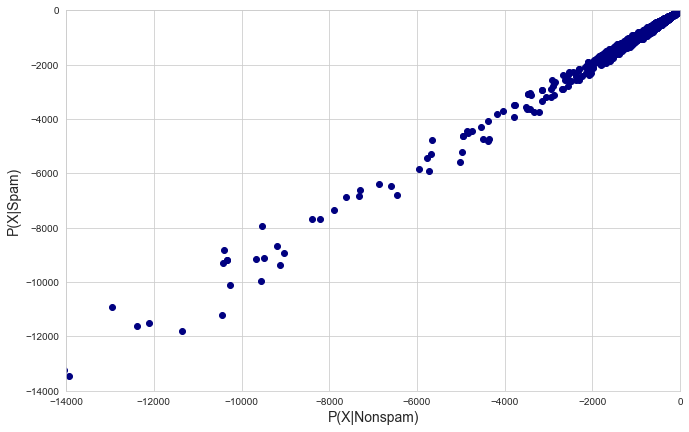

In [260]:
plt.figure(figsize=(11,7))
plt.xlabel(xaxis_label,fontsize=14)
plt.ylabel(yaxis_label,fontsize=14)

plt.xlim([-14000,1])
plt.ylim([-14000,1])

plt.scatter(joint_log_ham,joint_log_spam,color='navy')
plt.show()

## The Decision Boundary
### the line given by the orange color : the mails(points) that lie in the upper triangle(above the line) are spam and the other are non-spam

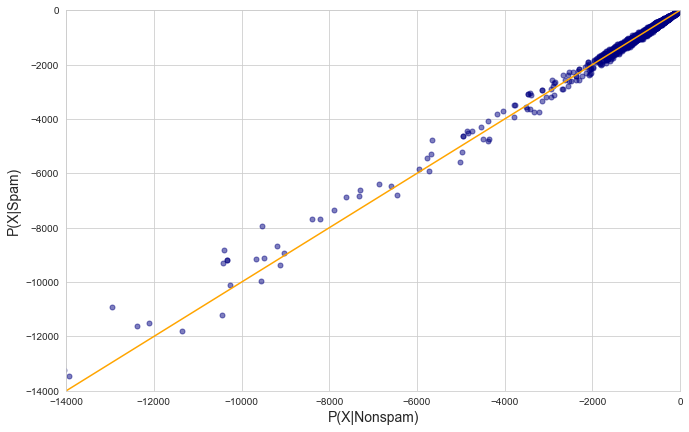

In [261]:
plt.figure(figsize=(11,7))
plt.xlabel(xaxis_label,fontsize=14)
plt.ylabel(yaxis_label,fontsize=14)

plt.xlim([-14000,1])
plt.ylim([-14000,1])

plt.scatter(joint_log_ham,joint_log_spam,color='navy',alpha=0.5,s=25)
plt.plot(lineddata,lineddata,color='orange')
plt.show()

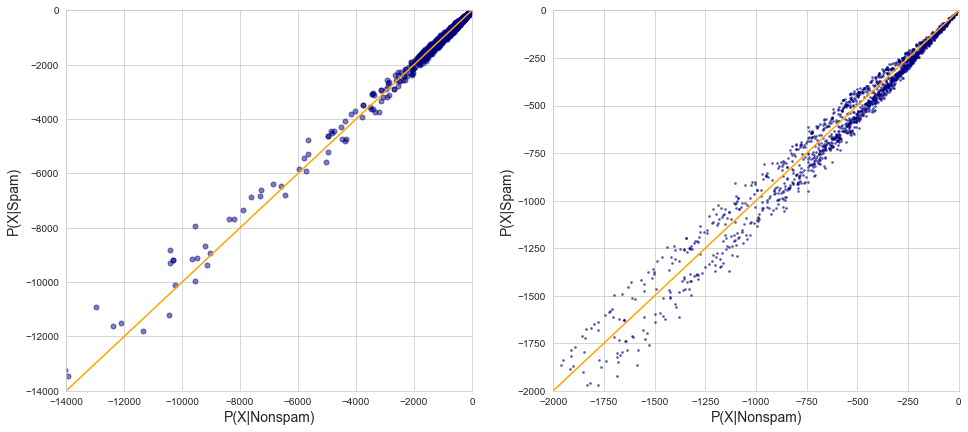

In [262]:
plt.figure(figsize=(16,7))

#chart 1
plt.subplot(1,2,1)
plt.xlabel(xaxis_label,fontsize=14)
plt.ylabel(yaxis_label,fontsize=14)

plt.xlim([-14000,1])
plt.ylim([-14000,1])

plt.scatter(joint_log_ham,joint_log_spam,color='navy',alpha=0.5,s=25)
plt.plot(lineddata,lineddata,color='orange')

#chart 2
plt.subplot(1,2,2)
plt.xlabel(xaxis_label,fontsize=14)
plt.ylabel(yaxis_label,fontsize=14)

plt.xlim([-2000,1])
plt.ylim([-2000,1])

plt.scatter(joint_log_ham,joint_log_spam,color='navy',alpha=0.5,s=3)
plt.plot(lineddata,lineddata,color='orange')
plt.show()

### plotting the graph using seaborn

In [263]:
sns.set_style('whitegrid')
labels = 'Actual Category'

summary_df = pd.DataFrame({yaxis_label: joint_log_spam, xaxis_label: joint_log_ham,labels: y_test})

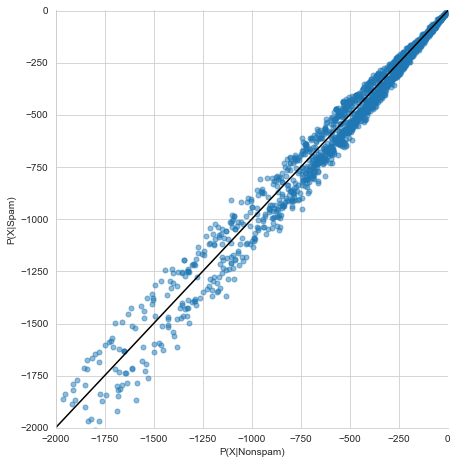

In [264]:
sns.lmplot(x=xaxis_label,y=yaxis_label,data=summary_df,height=6.5,fit_reg=False,
          scatter_kws={'alpha':0.5,'s':25})

plt.xlim([-2000,1])
plt.ylim([-2000,1])

plt.plot(lineddata,lineddata,color='black')
plt.show()

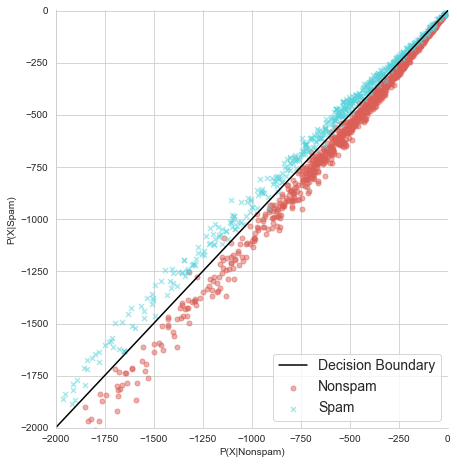

In [265]:
sns.lmplot(x=xaxis_label,y=yaxis_label,data=summary_df,height=6.5,fit_reg=False,legend=False,
          scatter_kws={'alpha':0.5,'s':25},hue=labels,markers=['o','x'],palette='hls')

plt.xlim([-2000,1])
plt.ylim([-2000,1])

plt.plot(lineddata,lineddata,color='black')
plt.legend(('Decision Boundary','Nonspam','Spam'),loc='lower right',fontsize=14)
plt.show()

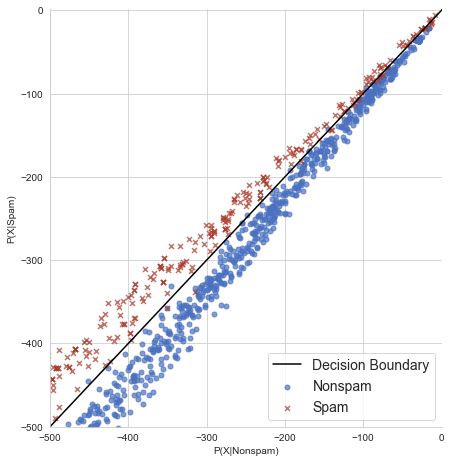

In [266]:
my_colours = ['#4A71C0', '#AB3A2C']

sns.lmplot(x=xaxis_label,y=yaxis_label,data=summary_df,height=6.5,fit_reg=False,legend=False,
          scatter_kws={'alpha':0.7,'s':25},hue=labels,markers=['o','x'],palette=my_colours)

plt.xlim([-500,1])
plt.ylim([-500,1])

plt.plot(lineddata,lineddata,color='black')
plt.legend(('Decision Boundary','Nonspam','Spam'),loc='lower right',fontsize=14)
plt.show()

## 2) False Positives and False Negatives

In [267]:
 np.unique(prediction,return_counts=True)

(array([False,  True]), array([1136,  588], dtype=int64))

In [268]:
true_pos = (y_test == 1) & (prediction == 1) #element by element comparision (this is bitwise and ,not boolean and)

In [269]:
true_pos.sum()

569

In [270]:
false_pos = (y_test == 0) & (prediction == 1)
false_neg = (y_test == 1) & (prediction == 0)

In [271]:
false_pos.sum()

19

In [272]:
false_neg.sum()

20

## 3) Recall Score

In [273]:
recall_score = true_pos.sum()/(true_pos.sum()+false_neg.sum())
print('the recall_score is {:.2%}'.format(recall_score))

the recall_score is 96.60%


## 4) Precision Score

In [274]:
precision_score = true_pos.sum()/(true_pos.sum()+false_pos.sum())
print('the precision_score is {:.3}'.format(precision_score))

the precision_score is 0.968


## 5) F-Score or F1 Score

In [275]:
f1_score = 2*(precision_score * recall_score)/(precision_score + recall_score)
print('the F score is {:.2}'.format(f1_score))

the F score is 0.97


## End of the Testing, Inference and Evaluation 
Tasks Accomplished:
    measured the performance of our classifier against various metrics
    
    1) Accuracy: Fraction classified correctly 97.74%
                 Fraction classified incorrectly 2.26%
    2) Recall Score : 96.60%
    3) Precision Score : 0.968
    4) F Score : 0.97